## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# Code to visualize the execution graph in the jupyter notebook
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    

In [2]:
import tensorflow as tf

In [3]:
def plot_image(image,title=None):
    plt.figure()
    plt.imshow(image, cmap="gray", interpolation="nearest")
    if title is not None:
        plt.title(title)
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
def getActivations(layer,data):
    units = sess.run(layer,feed_dict={in_training: False, X:np.reshape(data,[1,784],order='F')})
    plotNNFilter(units)

# visualize convolution activations
def plotNNFilter(units):
    filters = units.shape[3]
    #plt.figure(1, figsize=(20,20))
    plt.subplots(figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

# visualize convolution kernels
def plotConvLayerWeights(conv_layer_name, sess):
    kernel = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, conv_layer_name)[0]
    weights = sess.run(kernel)
    print(kernel.shape)
    
    n_filters = int(kernel.shape[3])
    n_base_layers = int(kernel.shape[2])
    plt.figure(figsize=(20,20))
    for j in range(n_base_layers):
        for i in range(n_filters):
            plt.subplot(n_base_layers, n_filters, j * n_filters + i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(weights[:,:,j,i].reshape(kernel.shape[0],kernel.shape[1]), cmap='gray', interpolation='nearest')
            plt.title(str(i+1))

## Load MNIST

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Select 1459 and 023678 from MNIST

Instructions for updating:
Use `tf.data.Dataset.from_tensor_slices()`.


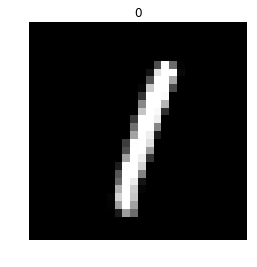

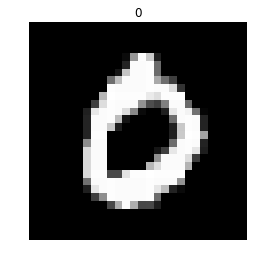

In [5]:
def prepare_data():
    global  dataset_1459_train, \
            dataset_023678_train, \
            X_1459_train, \
            y_1459_train, \
            X_1459_test, \
            y_1459_test, \
            X_023678_test, \
            y_023678_test, \
            X_023678_train, \
            y_023678_train
    mask_1459_train = np.logical_or.reduce([mnist.train.labels == v for v in [1,4,5,9]])
    mask_1459_test  = np.logical_or.reduce([mnist.test.labels  == v for v in [1,4,5,9]])
    X_1459_train = np.compress(np.array(mask_1459_train), mnist.train.images, axis=0)
    _, y_1459_train = np.unique(mnist.train.labels[mask_1459_train], return_inverse=True) # 1,4,5,9 to 0,1,2,3
    dataset_1459_train = tf.contrib.data.Dataset.from_tensor_slices((X_1459_train,y_1459_train))

    X_1459_test = np.compress(np.array(mask_1459_test), mnist.test.images, axis=0)
    _, y_1459_test = np.unique(mnist.test.labels[mask_1459_test], return_inverse=True)

    mask_023678_train = np.logical_or.reduce([mnist.train.labels == v for v in [0,2,3,6,7,8]])
    mask_023678_test  = np.logical_or.reduce([mnist.test.labels  == v for v in [0,2,3,6,7,8]])
    X_023678_train = np.compress(np.array(mask_023678_train), mnist.train.images, axis=0)
    _, y_023678_train = np.unique(mnist.train.labels[mask_023678_train], return_inverse=True) # 1,4,5,9 to 0,1,2,3
    dataset_023678_train = tf.contrib.data.Dataset.from_tensor_slices((X_023678_train,y_023678_train))

    X_023678_test = np.compress(np.array(mask_023678_test), mnist.test.images, axis=0)
    _, y_023678_test = np.unique(mnist.test.labels[mask_023678_test], return_inverse=True)

prepare_data()

# for example
plot_image(X_1459_test[2].reshape(28,28),title=y_1459_test[2])
plot_image(X_023678_test[2].reshape(28,28),title=y_023678_test[2])

# Convolutional Network

### Construct Graph

In [6]:
height = 28
width = 28
channels = 1
n_inputs = height * width
n_outputs = 4
drop_rate = 0.1
reset_graph()
prepare_data()

# inputs layer
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    in_training = tf.placeholder(tf.bool, name="in_training")

with tf.name_scope("conv"):
    conv1 = tf.layers.conv2d(X_reshaped, 4, 3, strides=(1, 1), padding = "SAME", activation=tf.nn.relu, name="conv1")
    conv1 = tf.layers.dropout(conv1, rate=drop_rate, training = in_training)
    conv2 = tf.layers.conv2d(conv1, 8, 3, strides=(2, 2), padding = "SAME", activation=tf.nn.relu, name="conv2")
    conv2 = tf.layers.dropout(conv2, rate=drop_rate,  training = in_training)
    
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                          padding='SAME', name = "pooling")
    pool3_flat = tf.reshape(pool3, [-1, 7*7*8])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, 16, activation=tf.nn.relu, name='fc1')
    fc1 = tf.layers.dropout(fc1, rate=drop_rate, training = in_training)
    
with tf.name_scope("fc2"):
    fc2 = tf.layers.dense(fc1, 10, activation=tf.nn.relu, name='fc2')

with tf.name_scope("output"):
    logits = tf.layers.dense(fc2, n_outputs)
    Y_proba = tf.nn.softmax(logits)

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

### Train 1459

Training...
0 Train accuracy: 0.978748 Test accuracy: 0.980836
1 Train accuracy: 0.988827 Test accuracy: 0.990791
2 Train accuracy: 0.991152 Test accuracy: 0.993031
3 Train accuracy: 0.992521 Test accuracy: 0.994525
4 Train accuracy: 0.993706 Test accuracy: 0.993778
Finished training
Loss curve for 1459


([<matplotlib.axis.XTick at 0x12965e610>,
 <a list of 5 Text xticklabel objects>)

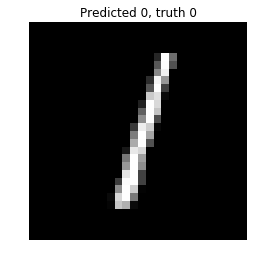

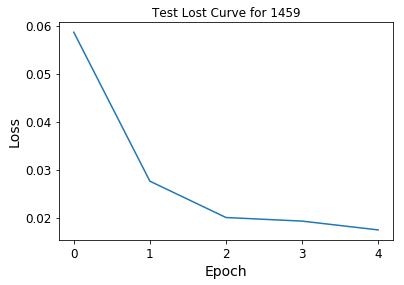

In [7]:
n_epochs = 5
batch_size = 10
test_loss_1459 = []
print("Training...")
with tf.Session() as sess:
    init.run()
    batched_dataset = dataset_1459_train.batch(batch_size)
    #test_loss_1459.append(sess.run(loss, feed_dict={X: X_1459_test, y: y_1459_test, in_training:False}))
    iterator = batched_dataset.make_initializable_iterator()
    next_batch = iterator.get_next()
    
    for epoch in range(n_epochs):
        sess.run(iterator.initializer)
        while True:
            try:
                X_batch, y_batch = sess.run(next_batch)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch, in_training:True})
            except tf.errors.OutOfRangeError:
                # finished running through dataset
                break

        acc_train = accuracy.eval(feed_dict={X: X_1459_train, y: y_1459_train, in_training:False})
        acc_test = accuracy.eval(feed_dict={X: X_1459_test, y: y_1459_test, in_training:False})
        test_loss_1459.append(sess.run(loss, feed_dict={X: X_1459_test, y: y_1459_test, in_training:False}))
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
    print("Finished training")

    save_path = saver.save(sess, "./my_model_1459.ckpt")
        
    # for example
    inferred = sess.run(Y_proba, feed_dict={X: [X_1459_test[0]], in_training:False})
    plot_image(X_1459_test[0].reshape(28,28), "Predicted %d, truth %d"%(np.argmax(inferred), y_1459_test[0]))

plt.subplots()
print("Loss curve for 1459")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Lost Curve for 1459')
plt.plot(test_loss_1459)
plt.xticks(range(len(test_loss_1459)))

### Build the graph for 023678

In [8]:
height = 28
width = 28
channels = 1
n_inputs = height * width
n_outputs = 6
reset_graph()
prepare_data()

# restore the graph of 1459
restore_saver = tf.train.import_meta_graph("./my_model_1459.ckpt.meta")

# reuse the inputs (X,y)
X = tf.get_default_graph().get_tensor_by_name("inputs/X:0")
y = tf.get_default_graph().get_tensor_by_name("inputs/y:0")
in_training = tf.get_default_graph().get_tensor_by_name("inputs/in_training:0")
# reuse the FC1 layer
fc1 = tf.get_default_graph().get_tensor_by_name("fc1/fc1/Relu:0")

# continue the 023678 graph from FC2...
with tf.name_scope("fc2_023678"):
    fc2 = tf.layers.dense(fc1, 10, activation=tf.nn.relu, name="fc2_023678")

with tf.name_scope("softmax_023678"):
    logits = tf.layers.dense(fc2, n_outputs , name="output_023678")
    Y_proba = tf.nn.softmax(logits, name="Y_proba_023678")

with tf.name_scope("train_023678"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer(name="adam_023678")
    training_op = optimizer.minimize(loss)

with tf.name_scope("train_023678_freezen"):
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="fc2_023678|softmax_023678")
    training_op_freezen = optimizer.minimize(loss, var_list=train_vars)

with tf.name_scope("eval_023678"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_023678"):
    init = tf.global_variables_initializer()
    new_saver = tf.train.Saver()

## Train transferred 023678

Training 023678...
INFO:tensorflow:Restoring parameters from ./my_model_1459.ckpt
0 Train accuracy: 0.976083 Test accuracy: 0.970913
1 Train accuracy: 0.982947 Test accuracy: 0.980776
2 Train accuracy: 0.986545 Test accuracy: 0.983952
Finished training
Loss curve for 023678
Training 023678 with freezen layers...
INFO:tensorflow:Restoring parameters from ./my_model_1459.ckpt
0 Train accuracy: 0.732108 Test accuracy: 0.729689
1 Train accuracy: 0.762465 Test accuracy: 0.760448
2 Train accuracy: 0.770901 Test accuracy: 0.767302
3 Train accuracy: 0.775527 Test accuracy: 0.769475
4 Train accuracy: 0.778823 Test accuracy: 0.77332
5 Train accuracy: 0.781483 Test accuracy: 0.775995
6 Train accuracy: 0.781604 Test accuracy: 0.775493
7 Train accuracy: 0.784356 Test accuracy: 0.778335
8 Train accuracy: 0.785112 Test accuracy: 0.779338
9 Train accuracy: 0.786714 Test accuracy: 0.77984
Finished training
Loss curve for 023678 with freezen layers


([<matplotlib.axis.XTick at 0x11727b190>,
 <a list of 10 Text xticklabel objects>)

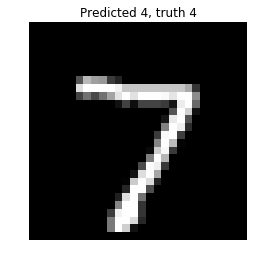

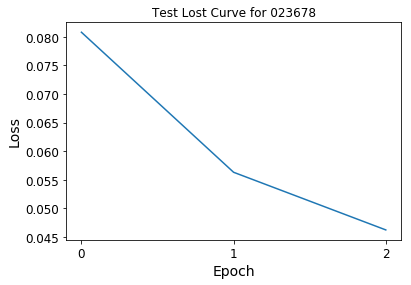

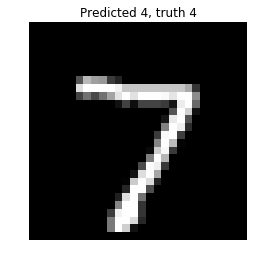

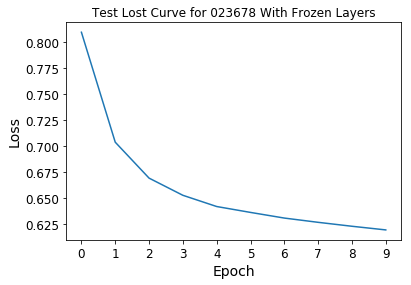

In [9]:
n_epochs = 3
batch_size = 10


test_loss_023678 = []
print("Training 023678...")
with tf.Session() as sess:
    init.run()
    batched_dataset = dataset_023678_train.batch(batch_size)
    #test_loss_023678.append(sess.run(loss, feed_dict={X: X_023678_test, y: y_023678_test, in_training: False}))
    iterator = batched_dataset.make_initializable_iterator()
    next_batch = iterator.get_next()
    
    saver.restore(sess, "./my_model_1459.ckpt")
    
    for epoch in range(n_epochs):
        sess.run(iterator.initializer)
 
        while True:
            try:
                X_batch, y_batch = sess.run(next_batch)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch, in_training:True})
                
            except tf.errors.OutOfRangeError:
                # finished running through dataset
                break

        acc_train = accuracy.eval(feed_dict={X: X_023678_train, y: y_023678_train, in_training: False})
        acc_test = accuracy.eval(feed_dict={X: X_023678_test, y: y_023678_test, in_training: False})
        test_loss_023678.append(sess.run(loss, feed_dict={X: X_023678_test, y: y_023678_test, in_training: False}))
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
    print("Finished training")

    # for example
    inferred = sess.run(Y_proba, feed_dict={X: [X_023678_test[0]], in_training: False})
    plot_image(X_023678_test[0].reshape(28,28), "Predicted %d, truth %d"%(np.argmax(inferred), y_023678_test[0]))
    
print("Loss curve for 023678")
plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Lost Curve for 023678')
plt.plot(test_loss_023678)
plt.xticks(range(len(test_loss_023678)))    


#####################################################    
    
# Session with freezen layers ...    
    
test_loss_023678_freezen = []
n_epochs = 10
print("Training 023678 with freezen layers...")
with tf.Session() as sess:
    init.run()
    batched_dataset = dataset_023678_train.batch(batch_size)
    #test_loss_023678_freezen.append(sess.run(loss, feed_dict={X: X_023678_test, y: y_023678_test, in_training: False}))
    iterator = batched_dataset.make_initializable_iterator()
    next_batch = iterator.get_next()
    
    saver.restore(sess, "./my_model_1459.ckpt")
    
    for epoch in range(n_epochs):
        sess.run(iterator.initializer)
 
        while True:
            try:
                X_batch, y_batch = sess.run(next_batch)
                sess.run(training_op_freezen, feed_dict={X: X_batch, y: y_batch, in_training:True})
                  
            except tf.errors.OutOfRangeError:
                # finished running through dataset
                break

        acc_train = accuracy.eval(feed_dict={X: X_023678_train, y: y_023678_train, in_training: False})
        acc_test = accuracy.eval(feed_dict={X: X_023678_test, y: y_023678_test, in_training: False})
        test_loss_023678_freezen.append(sess.run(loss, feed_dict={X: X_023678_test, y: y_023678_test, in_training: False}))
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
    print("Finished training")

    # for example
    inferred = sess.run(Y_proba, feed_dict={X: [X_023678_test[0]], in_training: False})
    plot_image(X_023678_test[0].reshape(28,28), "Predicted %d, truth %d"%(np.argmax(inferred), y_023678_test[0]))


print("Loss curve for 023678 with freezen layers")
plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Lost Curve for 023678 With Frozen Layers')
plt.plot(test_loss_023678_freezen)
plt.xticks(range(len(test_loss_023678_freezen)))  

## Visualize the Feature Maps
The following code is useful to look into the activations of convolutional and pooling layers

INFO:tensorflow:Restoring parameters from ./my_model_1459.ckpt
conv1
conv2
Pooling


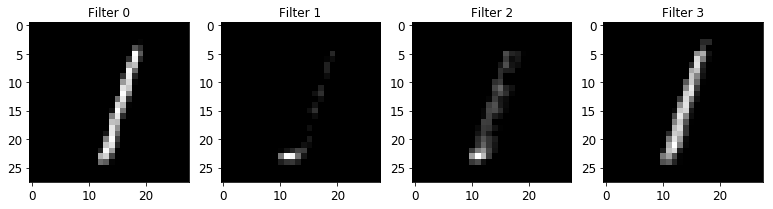

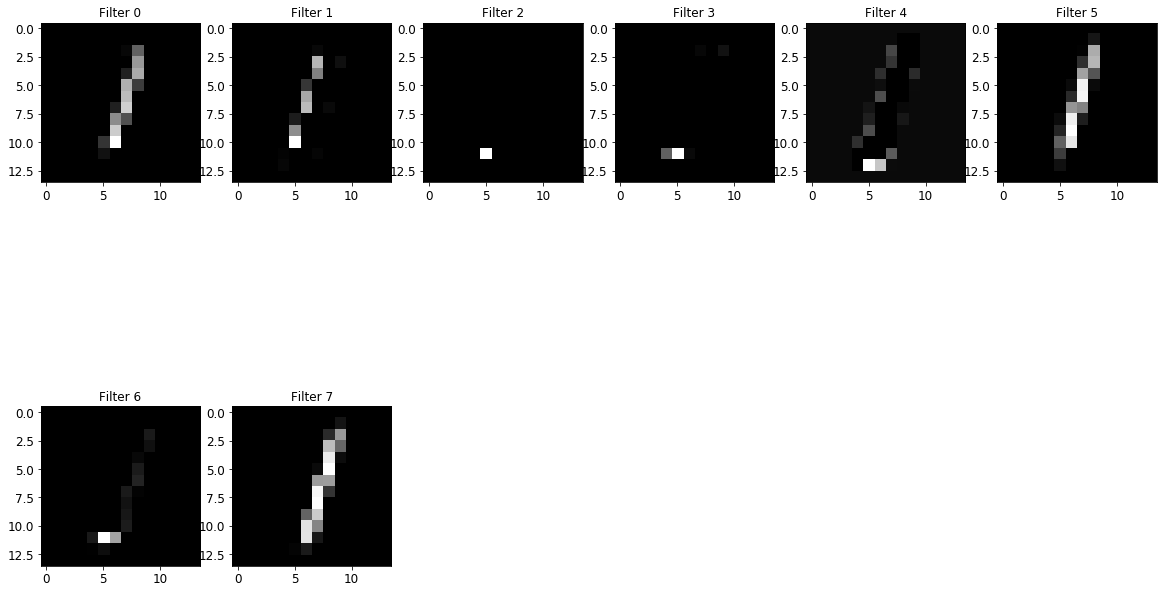

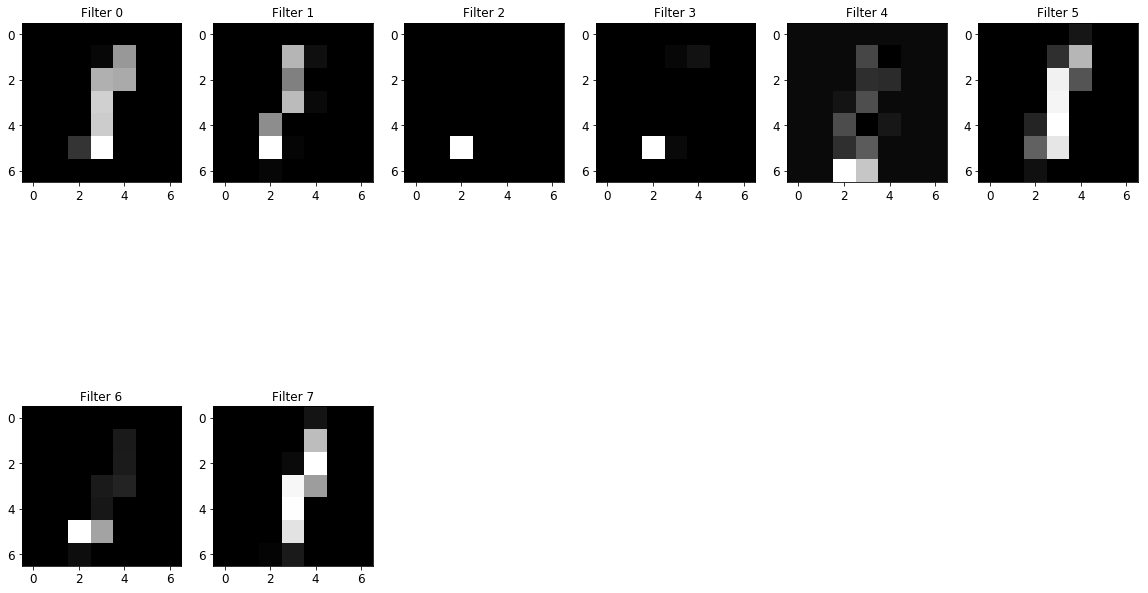

In [10]:
import math

with tf.Session() as sess:
    saver.restore(sess, "./my_model_1459.ckpt")
    
    print("conv1")
    getActivations(tf.get_default_graph().get_tensor_by_name("conv/conv1/Relu:0"), X_1459_test[0])
    
    print("conv2")
    getActivations(tf.get_default_graph().get_tensor_by_name("conv/conv2/Relu:0"), X_1459_test[0])

    print("Pooling")
    getActivations(tf.get_default_graph().get_tensor_by_name("pool3/pooling:0"), X_1459_test[0])

### Visualize the convolution kernels

INFO:tensorflow:Restoring parameters from ./my_model_1459.ckpt
conv1
(3, 3, 1, 4)
conv2
(3, 3, 4, 8)


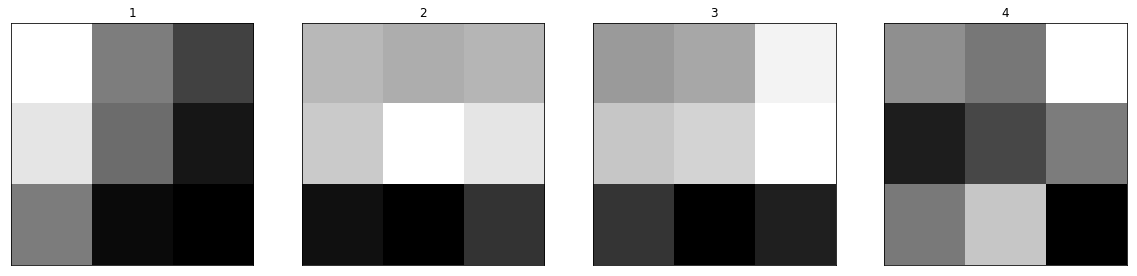

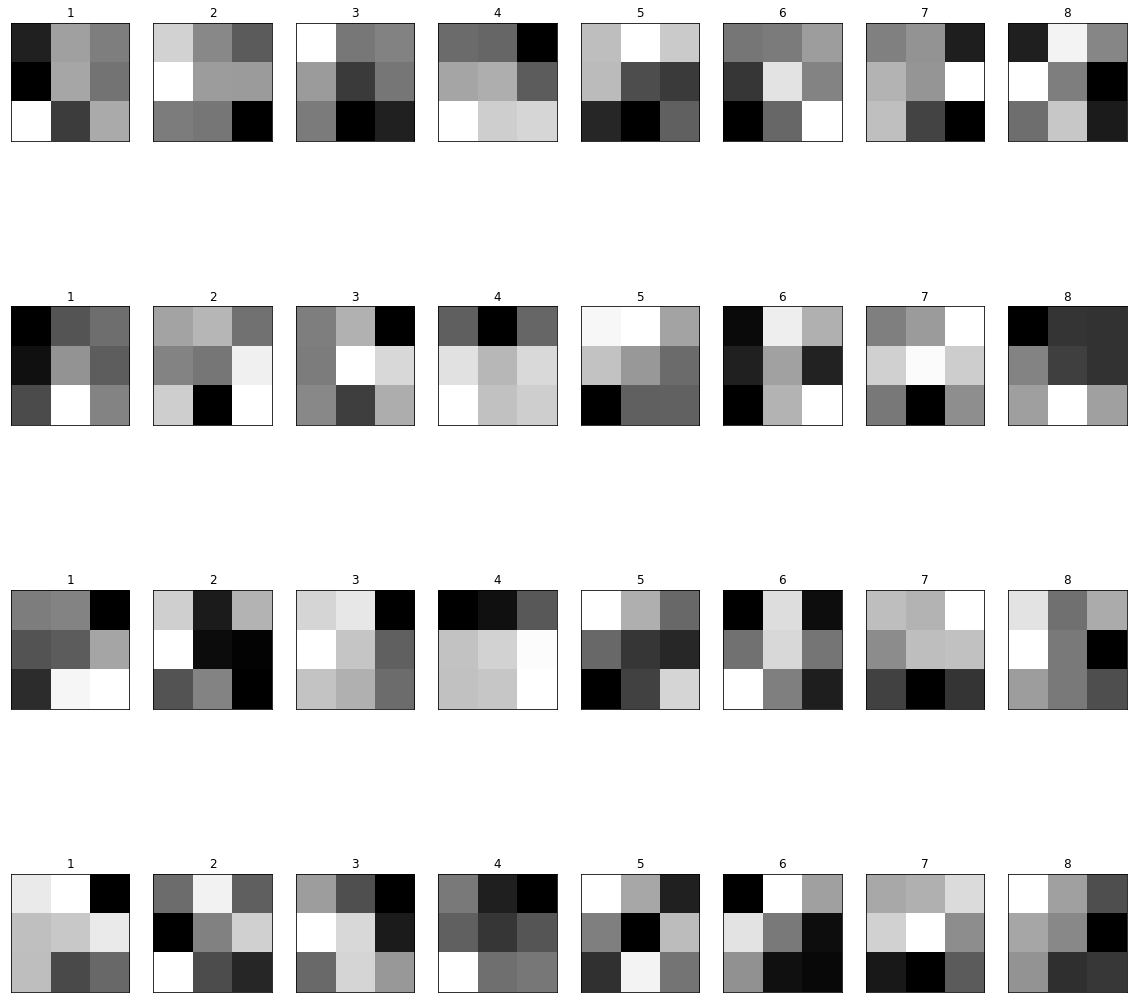

In [11]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_1459.ckpt")
    print("conv1")
    plotConvLayerWeights("conv1",sess)
    
    print("conv2")
    plotConvLayerWeights("conv2",sess)

## Show the Execution Graph

In [12]:
reset_graph()

# restore the graph of 1459
restore_saver = tf.train.import_meta_graph("./my_model_1459.ckpt.meta")
show_graph(tf.get_default_graph())